### Import Packages

In [1]:
import os
import ray
import time
import json
import pickle
import openai
import logging 
import requests 
import tiktoken
import numpy as np
import pandas as pd
import quantstats as qs
import statsmodels.api as sm
import pandas_datareader.data as web

from tqdm import tqdm
from math import ceil
from numba import jit
from sklearn.metrics import r2_score
from scipy.stats.mstats import winsorize
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# In order for ray to work, make sure you uninstall pydantic and reinstall this: pip install "pydantic<2"
from utils.system import *
from class_data.data import Data

# Set OPENAI KEY
os.environ["OPENAI_API_KEY"] = json.load(open(get_config() / 'api.json'))['openai_api_key']

# Set display
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings('ignore')

### Data

In [2]:
# Get SP500 candidates and set keys to the given year
def get_candidate():
    with open(get_data() / 'sp500_candidates.pkl', 'rb') as f:
        candidates = pickle.load(f)
    beginning_year = [date for date in candidates.keys() if date.month == 1]
    candidates = {date.year: candidates[date] for date in beginning_year if date in candidates}
    return candidates

# Get unique sp500 tickers
sp500_all = get_candidate()
sp500 = set()
for year, tickers in sp500_all.items():
    if year < 2000:
        continue
    sp500.update(tickers)
sp500 = list(sp500)

In [3]:
# Load openai embeddings
cc_emb = Data(folder_path=get_format_data() / 'openai', file_pattern='cc_emb_textemb3small_all_*')
cc_emb = cc_emb.concat_files()
cc_emb.shape

Loading Data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1198/1198 [00:13<00:00, 90.33it/s]


(1197859, 1)

In [4]:
# Load cc articles
cc_art = Data(folder_path=get_format_data() / 'art', file_pattern='cc_art_all_*')
cc_art = cc_art.concat_files()
cc_art.shape

Loading Data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.20it/s]


(1197859, 11)

In [5]:
# Remove NAN values
index = cc_emb.reset_index()
index_null = index.loc[index.ada_embedding.isnull()].index.tolist()
cc_art = cc_art.reset_index()
cc_art = cc_art.loc[~cc_art.index.isin(index_null)]
cc_art = cc_art.set_index(['fid', 'date'])
cc_emb = cc_emb.dropna()
print(cc_emb.shape)
print(cc_art.shape)

(1197847, 1)
(1197847, 11)


In [6]:
# Firm-Level Risk (2000-Present)
all_risk = pd.read_csv(get_data() / 'firmquarter_2022q1.csv', delimiter='\t', engine='python')
all_risk.date = pd.to_datetime(all_risk.date).dt.to_period('Q').dt.to_timestamp('Q')
all_risk.gvkey = all_risk.gvkey.astype('int64')
all_risk_gvkey = all_risk.gvkey.unique().tolist()
all_risk = all_risk.set_index(['gvkey', 'date'])
print(f"Length of all_risk GVKEY: {len(all_risk_gvkey)}")
print(f"Data Columns: \n{all_risk.columns.tolist()}")

Length of all_risk GVKEY: 13149
Data Columns: 
['PRisk', 'NPRisk', 'Risk', 'PSentiment', 'NPSentiment', 'Sentiment', 'PRiskT_economic', 'PRiskT_environment', 'PRiskT_trade', 'PRiskT_institutions', 'PRiskT_health', 'PRiskT_security', 'PRiskT_tax', 'PRiskT_technology', 'company_name', 'hqcountrycode', 'isin', 'cusip', 'ticker', 'date_earningscall', 'Covid_Exposure', 'Covid_Neg_Sentiment', 'Covid_Pos_Sentiment', 'Covid_Net_Sentiment', 'Covid_Risk', 'SARS_Exposure', 'H1N1_Exposure', 'Zika_Exposure', 'Ebola_Exposure', 'Brexit_Exposure', 'Brexit_Neg_Sentiment', 'Brexit_Pos_Sentiment', 'Brexit_Net_Sentiment', 'Brexit_Risk']


In [7]:
# # Firm-Level Risk (2002-2016)
# all_risk = pd.read_stata(get_data() / 'prisk_replication' / 'RestrictedReplication_FirmQuarter.dta')
# all_risk.gvkey = all_risk.gvkey.astype('int64')
# all_risk_gvkey = all_risk.gvkey.unique().tolist()
# all_risk['date'] = pd.to_datetime(all_risk['cdateQ']).dt.to_period('Q').dt.to_timestamp('Q')
# all_risk = all_risk.set_index(['gvkey', 'date'])
# all_risk = all_risk.sort_index(level=['gvkey', 'date'])
# print(f"Length of all_risk GVKEY: {len(all_risk_gvkey)}")
# print(f"Data Columns: \n{all_risk.columns.tolist()}")

In [8]:
# Link Data
link = pd.read_parquet(r'C:\Jonathan\QuantResearch\AlgoTradingModels\algofacto\trade_live\data_parquet\data_link.parquet.brotli')
link = link.loc[link.ticker.isin(sp500)]
link = link.drop_duplicates(subset='gvkey', keep='last')
link['gvkey'] = link['gvkey'].astype('int64')
sp500_gvkey = link['gvkey'].unique().tolist()
ticker_to_gvkey_mapping = link.set_index('ticker')['gvkey'].to_dict()
gvkey_to_ticker_mapping = link.set_index('gvkey')['ticker'].to_dict()

### Query

In [9]:
# Params
p_val = 0.20
query = "Risk, Uncertainty, Politics, Policy, Government, Regulation, Stability, Election, Legislation, Economy, Political risk, Policy uncertainty, Government regulation, Economic policy, Legislative changes, Risk management, Market stability, Political stability, Regulatory framework, Economic instability, Level of uncertainty, Impact of regulation, Government policy changes, Political risk assessment, Economic policy uncertainty, Long term stability, Risk assessment process, Political instability risk, Regulatory compliance issues, Political climate change"
# query = "the constitution, the states, public opinion, interest groups, of government, the GOP, in Congress, national government, social policy, the civil, elected officials, politics is, political parties, office of, the political, interest group, the bureaucracy, and Senate, government and, for governor, executive branch, support for, the EPA, in government, Congress to, political process, care reform, government in, due process, President Obama, and social, first amendment, Congress the, the Republican, Tea Party, the legislative, of civil, court has, groups and, struck down, shall have, civil war, the Congress, the constitutional, ruled that, the presidential, of representatives, policy goals, African Americans, economic policy, of social, a political, of speech, civil service, government policy, federal courts, argued that, the democratic, islamic state, governor and, government the, this election, political party, American political, politics of, White House, the politics, general election, and political, policy is, the islamic, Federal Reserve, judicial review, vote for, limits on, the FAA, the presidency, shall not, the nation, constitution and, Senate and, the VA, of citizens, any state, the electoral, a president, the governments, clause of, and Congress, the partys, the Taliban, a yes, other nations, passed by, states or, free market, that Congress, national and, most Americans, of religion, powers and, a government, politics and, the South, government is, yes vote, to enact, political system, proposed by, the legislature, the campaign, federal bureaucracy, and party, governor in, state the, executive privilege, of politics, the candidates, national security"
# query = "Definition of Artificial Intelligence. History of AI development. Machine Learning and AI. Deep Learning techniques. Natural Language Processing in AI. Computer Vision and AI. AI in Robotics. Ethical considerations of AI. AI and job automation. AI in healthcare diagnostics. AI applications in finance. AI-driven data analysis. AI in autonomous vehicles. AI in smart home technology. AI in video games and entertainment. AI in educational technology. AI and cybersecurity. AI in social media algorithms. AI in climate change and environmental modeling. AI in space exploration. AI in agricultural technology. AI in supply chain and logistics. AI in legal document analysis. AI in language translation services. AI in content creation and journalism. AI in facial recognition technology. AI in virtual assistants. AI and the future of work. AI in predictive maintenance. AI in scientific research. Bias and fairness in AI systems. AI and privacy concerns. AI and intellectual property rights. AI in military and defense applications. AI in emergency response and disaster management. AI in customer service automation. AI in drug discovery and pharmaceuticals. AI and blockchain technology. AI in real estate analysis. AI in wearable technology and health monitoring. AI in art and creative design. AI in sports analytics and performance improvement. AI in cooking and recipe creation. AI in retail and personalized shopping experiences. AI and the impact on human relationships. AI in talent recruitment and HR processes. AI in manufacturing and industrial automation. AI in elder care and assistive technologies. AI in urban planning and smart cities. The role of quantum computing in AI."
# query = "Environmental, Social, and Governance principles. Sustainable investing strategies. Corporate social responsibility in business practices. Impact of climate change on investment decisions. Socially responsible investment trends. Governance and ethics in corporate management. Environmental sustainability in corporate operations. Financial performance of ESG-compliant companies. Regulatory compliance with ESG standards. Stakeholder activism in ESG issues. Green bonds and sustainable finance. Diversity and inclusion in the workplace. Renewable energy investments. Carbon footprint reduction strategies for businesses. Supply chain sustainability and ethical sourcing. Corporate philanthropy and community engagement. Employee welfare and labor rights. Transparency and accountability in corporate reporting. Impact investing and ESG-focused funds. Shareholder proposals on environmental and social issues. Corporate governance reforms and best practices. ESG risk assessment and management. Sustainability reporting standards and frameworks. Climate risk disclosure and financial implications. Energy efficiency initiatives in the corporate sector. Water conservation and management in business operations. Anti-corruption policies and ethical business conduct. Board diversity and leadership in ESG implementation. Human rights compliance in global supply chains. Investor engagement on ESG performance."
# query = "Definition of Cybersecurity. History of cybersecurity. Key cybersecurity technologies. Cybersecurity in network systems. Threat detection and management. Malware analysis and antivirus solutions. Cryptography in cybersecurity. Firewalls and perimeter defenses. Vulnerability assessments in cybersecurity. Penetration testing techniques. Cybersecurity in cloud computing. Cybersecurity standards and frameworks. Data protection laws and regulations. Cybersecurity in critical infrastructure. Cybersecurity training and awareness programs. Incident response and disaster recovery. Cybersecurity in financial services. Threat intelligence in cybersecurity. Endpoint security solutions. Secure application development. Cybersecurity in Internet of Things (IoT). Blockchain for enhanced security. Artificial Intelligence in cybersecurity. Cybersecurity in healthcare data protection. Mobile security challenges and solutions. Cybersecurity in government and military. Ethical hacking and security testing. Cybersecurity for small and medium enterprises. Cyber threats and the future of cybersecurity. Cybersecurity insurance and risk management. Phishing and social engineering prevention. Cybersecurity in e-commerce. Cybersecurity certifications and careers. Privacy and personal data protection. Cybersecurity in social media. Cybersecurity in telecommunications. Cybersecurity audits and compliance checks. User authentication and access control. Cybersecurity in automotive systems. Cybersecurity in educational institutions. Impact of quantum computing on cybersecurity. Cybersecurity in smart home technology. Cybersecurity in media and entertainment. Cybersecurity in electoral systems. Cybersecurity in shipping and logistics. Cybersecurity and national security. Cybersecurity in space technology. Cybersecurity in virtual reality and augmented reality."

In [10]:
# Get embedding of query
def get_emb(query):
    return np.array(openai.embeddings.create(input=[query.replace("\n", " ")], model='text-embedding-3-small').data[0].embedding).reshape(1, -1)

In [11]:
# Batch cosine similarity
def batch_cosine_similarity(query, embeddings, batch_size=100000):
    num_embeddings = len(embeddings)
    scores = np.zeros(num_embeddings, dtype=np.float32)
    for start in range(0, num_embeddings, batch_size):
        end = start + batch_size
        batch_embeddings = np.stack(embeddings[start:end]).astype(np.float32)
        scores[start:end] = cosine_similarity(query, batch_embeddings)[0]
    return scores

In [12]:
# Calculate score
query_emb = get_emb(query)
score = batch_cosine_similarity(query_emb, cc_emb['ada_embedding'])
score = pd.DataFrame(score, index=cc_emb.index, columns=['score'])

In [13]:
# Relu Transformation
scores = np.array(score['score'])
percentile = 100 * (1 - p_val)
threshold = np.percentile(scores, percentile)
relu_score = np.maximum(0, score['score'] - threshold)
relu_score = relu_score.to_frame('score')

In [14]:
# Add metadata
relu_score['body_txt'] = cc_art['body_txt']
relu_score['word_count'] = cc_art['word_count']
relu_score['ticker'] = cc_art['companyTicker']
relu_score['content_type'] = cc_art['content_type']

In [15]:
# Change index to ('ticker', 'date')
relu_score = relu_score.reset_index().set_index(['ticker', 'date'])

In [16]:
# Get article associated to the maximum score per date
mask = (relu_score['score'] == relu_score.groupby(['ticker', 'date'])['score'].transform('max'))
max_article = relu_score[mask]
max_article = max_article[~max_article.index.duplicated(keep='first')]

In [17]:
# # Read through max article scores
# max_article_50 = max_article.sort_values('score').tail(50)
# max_article_50.to_csv(get_data() / 'cc_article' / 'cc_prisk_all.csv')

<Axes: >

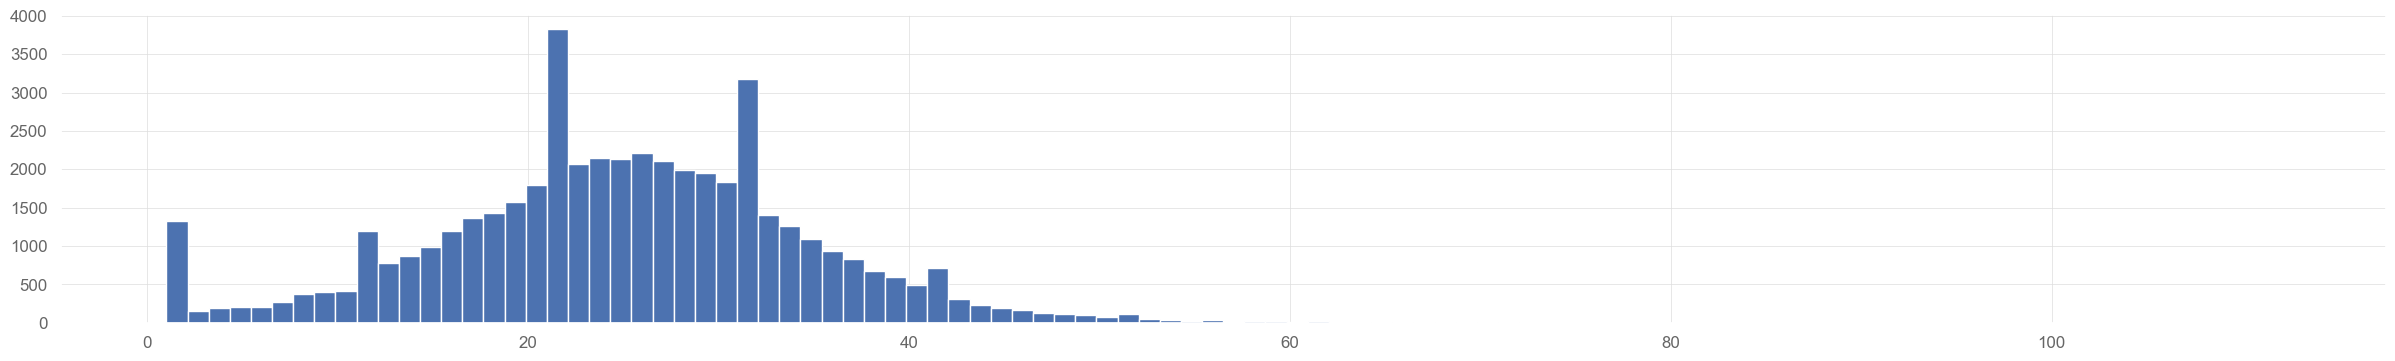

In [18]:
# Number of QAs per ticker, date
relu_score.groupby(['ticker', 'date']).count().score.hist(bins=100, figsize=(30, 4))

In [19]:
# Calculate aggregrated score per date
# Mean score
mean_score = relu_score.groupby(['ticker', 'date'])[['score']].mean()

# # Weighted word count mean score
# weighted_score_sum = (relu_score['score'] * relu_score['word_count']).groupby(['ticker', 'date']).sum()
# total_words = relu_score.groupby(['ticker', 'date'])['word_count'].sum()
# mean_score = weighted_score_sum / total_words

# Log weighted word count score
# relu_score['log_weighted_score'] = relu_score['score'] * np.log1p(relu_score['word_count'])
# mean_score = relu_score.groupby(['ticker', 'date'])['log_weighted_score'].sum()

In [20]:
# Calculate aggregrated score per quarter
mean_score = mean_score.groupby('ticker')[['score']].resample('Q', level='date').mean()
mean_score = mean_score.fillna(0)

### GVKEY join with PRisk

In [21]:
# Param
risk = 'PRisk'

In [22]:
# Set risk
compare_risk = all_risk[[risk]]

In [23]:
# Map ticker to gvkey
mean_score['gvkey'] = mean_score.index.get_level_values('ticker').map(ticker_to_gvkey_mapping)
print(f"Unique Tickers: {len(mean_score.index.get_level_values('ticker').unique())}")
mean_score = mean_score.dropna(subset='gvkey')
print(f"Unique Tickers with gvkey: {len(mean_score.index.get_level_values('ticker').unique())}")
mean_score['gvkey'] = mean_score['gvkey'].astype('int64')
mean_score = mean_score.reset_index().set_index(['gvkey', 'date'])
mean_score = mean_score.drop(columns='ticker')

Unique Tickers: 655
Unique Tickers with gvkey: 642


<Axes: >

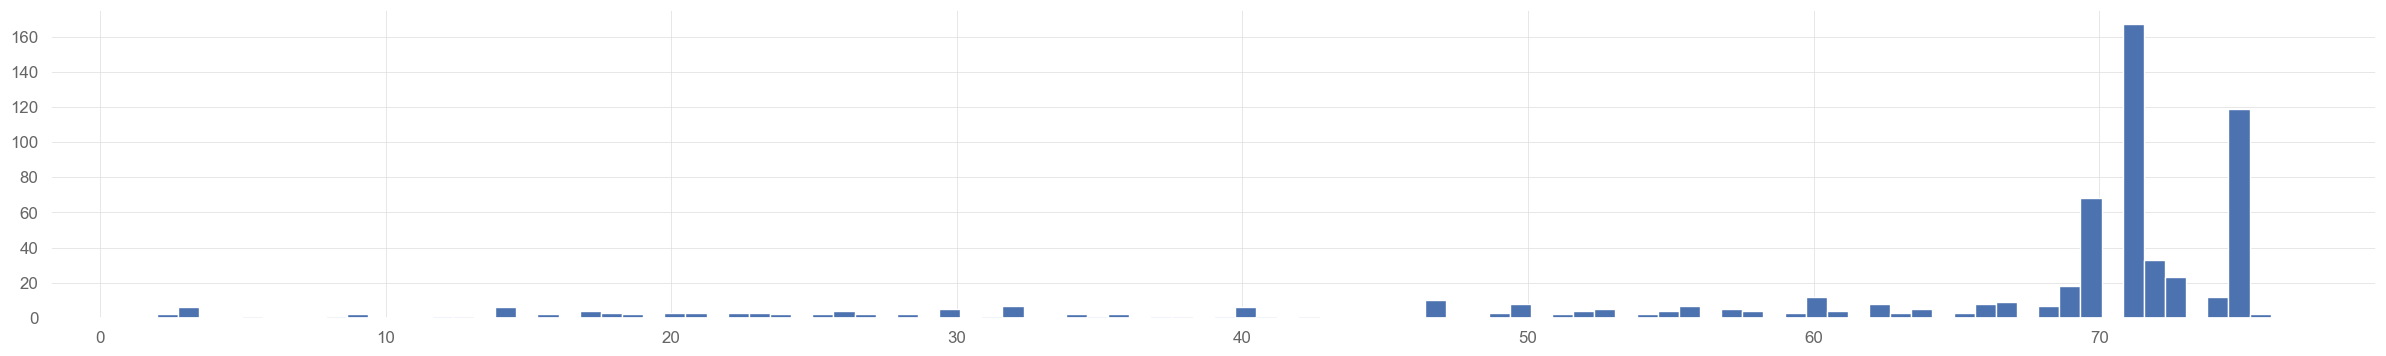

In [24]:
# Number of CC per GVKEY
counts_per_gvkey = mean_score.groupby('gvkey').size()
counts_per_gvkey.hist(bins=100, figsize=(30, 4))

In [25]:
# Join
compare = mean_score.join(compare_risk)
characteristic_port = compare.copy(deep=True)
compare = compare.dropna()

In [26]:
# Filter out tickers with less than 20 CC
compare = compare.groupby('gvkey').filter(lambda x: len(x) >=20)
print(f"Unique Tickers with more than 20 CC for score and firm-level risk: {len(compare.index.get_level_values('gvkey').unique())}")

Unique Tickers with more than 20 CC for score and firm-level risk: 593


In [27]:
# Standardize
minmax_compare = compare.copy(deep=True)
scaler = MinMaxScaler()
columns_to_scale = minmax_compare.columns
minmax_compare[columns_to_scale] = scaler.fit_transform(minmax_compare[columns_to_scale])

### Correlation

In [28]:
# Calculate correlations (three cases: shift(-1), shift(1), no shift - must do this because do not know exactly how Firm-Level Risk Aggregated)
def calc_corr_case(group):
    # Calculate correlations
    corr_current = group['score'].corr(group['PRisk'])
    corr_shifted_forward = group['score'].shift(1).corr(group['PRisk'])
    corr_shifted_backward = group['score'].shift(-1).corr(group['PRisk'])
    # Store correlations in a dictionary
    correlations = {
        'shift_none': corr_current,
        'shift_forward_1': corr_shifted_forward,
        'shift_backward_1': corr_shifted_backward
    }
    # Store these values
    group['store_corr'] = group.apply(lambda x: [round(corr_current, 2), round(corr_shifted_forward, 2), round(corr_shifted_backward, 2)], axis=1)
    # Find the largest correlation and its corresponding label
    max_corr_label, max_corr_value = max(correlations.items(), key=lambda x: x[1])
    # Update the group DataFrame with the best correlation label
    group['best_corr'] = max_corr_label
    if max_corr_label == 'shift_none':
        group['score_best_corr'] = group['score']
    elif max_corr_label == 'shift_forward_1':
        group['score_best_corr'] = group['score'].shift(1)
    elif max_corr_label == 'shift_backward_1':
        group['score_best_corr'] = group['score'].shift(-1)
    return group

In [29]:
# Apply functions to each group
compare_date = minmax_compare.groupby('gvkey').apply(calc_corr_case).reset_index(level=0, drop=True)
compare_date = compare_date.dropna()
display(compare_date.head(2))

score  PRisk             store_corr        best_corr  \
gvkey date                                                               
1045  2002-09-30 0.0968 0.0323  [-0.05, -0.04, -0.15]  shift_forward_1   
      2002-12-31 0.0000 0.0755  [-0.05, -0.04, -0.15]  shift_forward_1   

                  score_best_corr  
gvkey date                         
1045  2002-09-30           0.0808  
      2002-12-31           0.0968

In [30]:
# Firm-by-firm Correlation
firm_corr = compare_date.groupby(['gvkey']).apply(lambda x: x['score_best_corr'].corr(x['PRisk'])).to_frame('corr')
print(f"Average Correlation: {round(firm_corr.mean().values[0], 2)}")
print(f"STD Correlation: {round(firm_corr.std().values[0], 2)}")
print(f"Max Correlation: {round(firm_corr.max().values[0], 2)}")
print(f"Min Correlation: {round(firm_corr.min().values[0], 2)}")

Average Correlation: 0.22
STD Correlation: 0.15
Max Correlation: 0.72
Min Correlation: -0.26


Average Correlation: 0.31
STD Correlation: 0.07
Max Correlation: 0.51
Min Correlation: 0.15


<Axes: xlabel='date'>

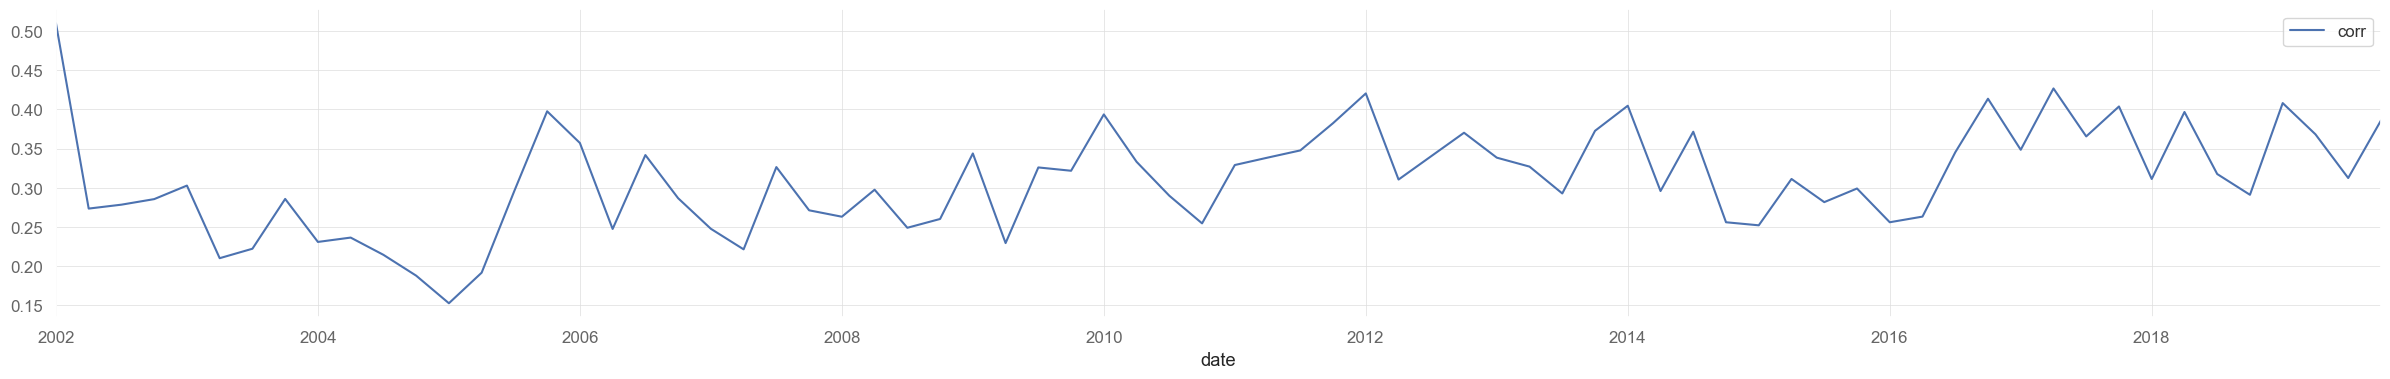

In [31]:
# Date-by-date Correlation
corr = compare_date.groupby(['date']).apply(lambda x: x['score_best_corr'].corr(x['PRisk'])).to_frame('corr')
print(f"Average Correlation: {round(corr.mean().values[0], 2)}")
print(f"STD Correlation: {round(corr.std().values[0], 2)}")
print(f"Max Correlation: {round(corr.max().values[0], 2)}")
print(f"Min Correlation: {round(corr.min().values[0], 2)}")

# Plot
corr.plot(figsize=(30, 4))

In [32]:
# Cross-sectional Correlation
print(f"Cross-sectional Correlation: {round(compare_date['score_best_corr'].corr(compare_date['PRisk']), 2)}")

Cross-sectional Correlation: 0.32


<Axes: xlabel='gvkey,date'>

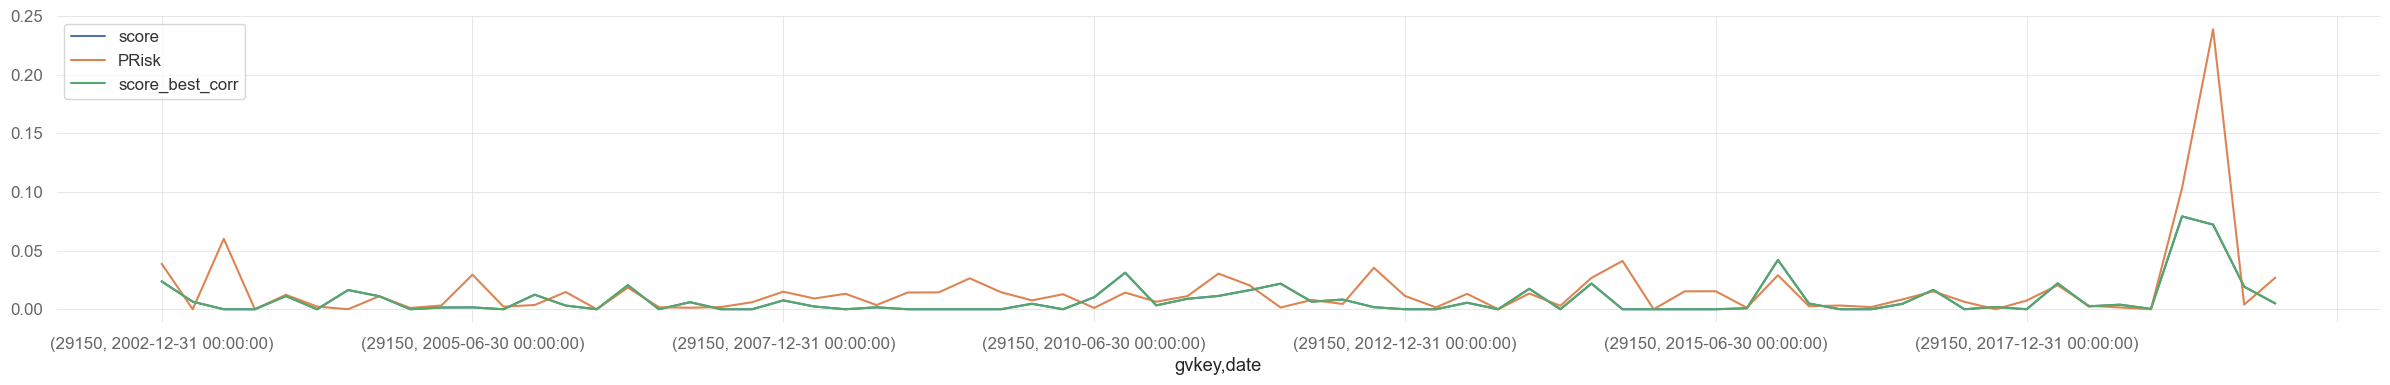

In [33]:
# Plot Max
max_corr_gvkey = firm_corr.loc[firm_corr['corr'] == firm_corr['corr'].max()].index[0]
max_corr_index = compare_date.loc[compare_date.index.get_level_values('gvkey') == max_corr_gvkey]
max_corr_index.plot(figsize=(30, 4))

<Axes: xlabel='gvkey,date'>

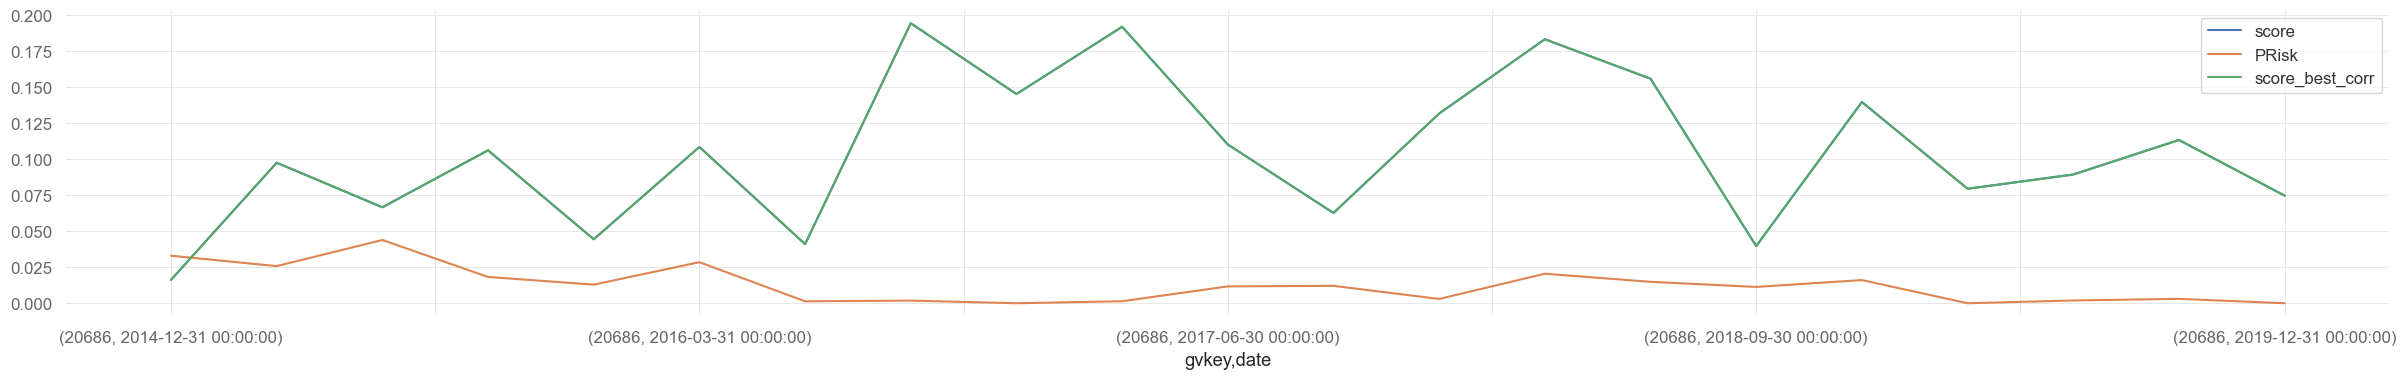

In [34]:
# Plot Min
min_corr_gvkey = firm_corr.loc[firm_corr['corr'] == firm_corr['corr'].min()].index[0]
min_corr_index = compare_date.loc[compare_date.index.get_level_values('gvkey') == min_corr_gvkey]
min_corr_index.plot(figsize=(30, 4))

### Load in JKP

In [35]:
# Load JKP daily ret
daily_ret = Data(folder_path=get_format_data() / 'jkp', file_pattern='daily_ret_*')
daily_ret = daily_ret.concat_files()
daily_ret.shape

Loading Data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.05it/s]


(219492890, 6)

In [36]:
# Load JKP daily ret
characteristics = Data(folder_path=get_format_data() / 'jkp', file_pattern='characteristics_*')
characteristics = characteristics.concat_files()
characteristics = characteristics.dropna(subset='gvkey')
characteristics['gvkey'] = characteristics['gvkey'].astype('int64')
characteristics.shape

Loading Data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.22it/s]


(3394206, 444)

In [37]:
# Create id and gvkey map to join JKP datasets
id_gvkey = characteristics[['id', 'gvkey']]
id_gvkey = id_gvkey.drop_duplicates(subset='gvkey', keep='last')
id_to_gvkey_mapping = id_gvkey.set_index('id')['gvkey'].to_dict()

In [38]:
# Add gvkey to JKP dataset
daily_ret['gvkey'] = daily_ret['id'].map(id_to_gvkey_mapping)
daily_ret = daily_ret.dropna(subset='gvkey')
daily_ret['gvkey'] = daily_ret['gvkey'].astype('int64')

In [39]:
# Retrieve GVKEY data used in index
daily_ret = daily_ret.loc[daily_ret.gvkey.isin(all_risk_gvkey)]
characteristics = characteristics.loc[characteristics.gvkey.isin(all_risk_gvkey)]

In [40]:
# Convert date to datetime
daily_ret['date'] = pd.to_datetime(daily_ret['date'], format='%Y%m%d')
characteristics['date'] = pd.to_datetime(characteristics['date'], format='%Y%m%d')

In [41]:
# Set index
daily_ret = daily_ret.set_index(['gvkey', 'date'])
characteristics = characteristics.set_index(['gvkey', 'date'])

### Prepare Data

In [42]:
# Calculate sum quarterly return
ret_q = daily_ret.groupby('gvkey')[['ret']].resample('Q', level='date').sum()

In [43]:
# Calculate quarterly volatility
vol_q = daily_ret.groupby('gvkey')[['ret']].resample('Q', level='date').std()
vol_q.columns = ['vol']

In [44]:
# Get quarterly asset
asset_q = characteristics.groupby('gvkey')[['assets']].resample('Q', level='date').last()

### Characteristic Portfolio Alpha

In [45]:
# Read in Fama Data
fama_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start=2000)[0].rename(columns={'Mkt-RF': 'MARKET'}))
fama_data.index.names = ['date']
fama_data = fama_data.astype(float)
fama_data = fama_data / 100
fama_data = fama_data.drop('RF', axis=1)
fama_data.columns = ['mkt_rf', 'smb', 'hml', 'rmw', 'cma']
fama_data = fama_data.resample('Q').sum()

In [46]:
# Join
factor_port = characteristic_port.join(ret_q)
factor_port = factor_port.join(asset_q)

In [47]:
# Calculate N percentile strategy returns
def percentile_ret(backtest, characteristic, N):
    # Apply to each group of data (grouped by date)
    def calc_percentile_ret(group):
        # Sort by predicted return
        sorted_group = group.sort_values(characteristic, ascending=False)
        
        # Select top N and bottom N
        top_n = sorted_group.head(N)
        bottom_n = sorted_group.tail(N)
        
        # Assign weights
        top_weights = pd.Series([1/N] * N, index=top_n.index)
        bottom_weights = pd.Series([-1/N] * N, index=bottom_n.index)
        
        # Combine weights
        weights = pd.concat([top_weights, bottom_weights])
        # weights /= weights.abs().sum()
        
        # Calculate weighted returns
        weighted_returns = group['ret'].mul(weights)
        
        # Sum returns for the date
        return weighted_returns.sum()
    
    # Group by date and apply the function
    returns = backtest.groupby('date').apply(calc_percentile_ret)
    return returns

In [48]:
# Params
N = 20
print(F"Number of firms per quarter: \n\n{factor_port.groupby('date').count().score.tolist()}")

Number of firms per quarter: 

[4, 138, 149, 170, 202, 380, 458, 475, 480, 484, 490, 493, 496, 499, 505, 506, 515, 516, 519, 523, 527, 529, 530, 535, 539, 542, 549, 552, 552, 561, 562, 563, 563, 564, 565, 566, 570, 570, 571, 572, 573, 574, 575, 575, 580, 581, 586, 586, 588, 590, 593, 595, 597, 600, 603, 606, 610, 612, 616, 620, 620, 619, 619, 620, 616, 612, 607, 604, 603, 600, 599, 594, 590, 587, 583, 579, 1]


In [49]:
# Filter out dates with less than 30 firms
factor_port = factor_port.groupby('date').filter(lambda x: len(x) > 30)

In [50]:
# Attention Premium
score_ret = percentile_ret(factor_port, 'score', N).to_frame('score_ret')

In [51]:
# PRisk Premium
prisk_ret = percentile_ret(factor_port.dropna(subset='PRisk'), 'PRisk', N).to_frame('prisk_ret')

In [52]:
# Join
alpha_score = score_ret.join(fama_data)
alpha_prisk = prisk_ret.join(fama_data)

In [54]:
# Alpha
X = sm.add_constant(alpha_score[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']])
y = alpha_score['score_ret']

# Create the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print out the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              score_ret   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.6694
Date:                Thu, 02 May 2024   Prob (F-statistic):              0.648
Time:                        02:07:52   Log-Likelihood:                 98.935
No. Observations:                  75   AIC:                            -185.9
Df Residuals:                      69   BIC:                            -172.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0228      0.009     -2.508      0.0

In [55]:
# Alpha
X = sm.add_constant(alpha_prisk[['mkt_rf', 'smb', 'hml', 'rmw', 'cma']])
y = alpha_prisk['prisk_ret']

# Create the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print out the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              prisk_ret   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.9236
Date:                Thu, 02 May 2024   Prob (F-statistic):              0.471
Time:                        02:07:53   Log-Likelihood:                 133.03
No. Observations:                  72   AIC:                            -254.1
Df Residuals:                      66   BIC:                            -240.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.005     -0.295      0.7

In [57]:
def calc_annual_sharpe(data, col):
    mean_excess_return = data[col].mean()
    std_deviation = data[col].std()
    annualized_mean_excess_return = mean_excess_return * 4
    annualized_std_deviation = std_deviation * np.sqrt(4)
    annualized_sharpe_ratio = annualized_mean_excess_return / annualized_std_deviation
    print(f"Annualized Sharpe Ratio {col}:", annualized_sharpe_ratio)

calc_annual_sharpe(alpha_score, 'score_ret')
calc_annual_sharpe(alpha_score, 'mkt_rf')

Annualized Sharpe Ratio score_ret: -0.691543924700279
Annualized Sharpe Ratio mkt_rf: 0.5250082834068021


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2001-06-30   2001-06-30
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          270.69%      -85.28%
CAGR﹪                     5.01%        -6.89%

Sharpe                     4.17         -5.49
Prob. Sharpe Ratio         97.96%       0.76%
Smart Sharpe               3.36         -4.43
Sortino                    6.21         -6.51
Smart Sortino              5.01         -5.25
Sortino/√2                 4.39         -4.6
Smart Sortino/√2           3.54         -3.71
Omega                      0.38         0.38

Max Drawdown               -42.18%      -84.63%
Longest DD Days            1097         6667
Volatility (ann.)          125.95%      105.87%
R^2                        0.01         0.01
Information Ratio          -0.44        -0.44
Calmar     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2001-09-30,2019-12-31,2019-12-31,6667,-84.6257,-84.4291


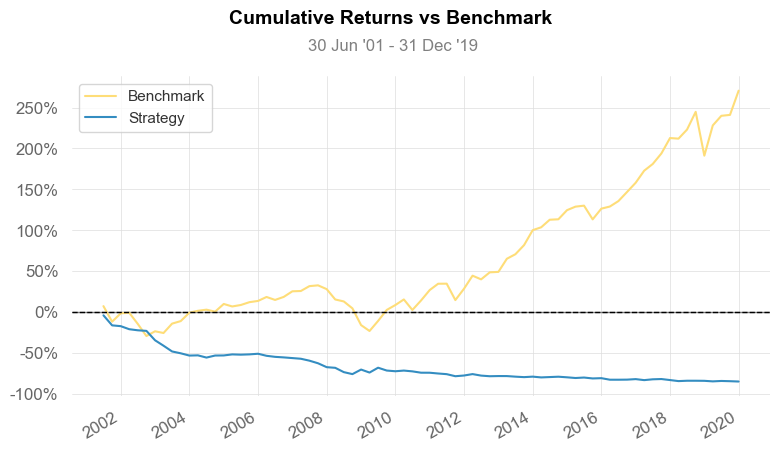

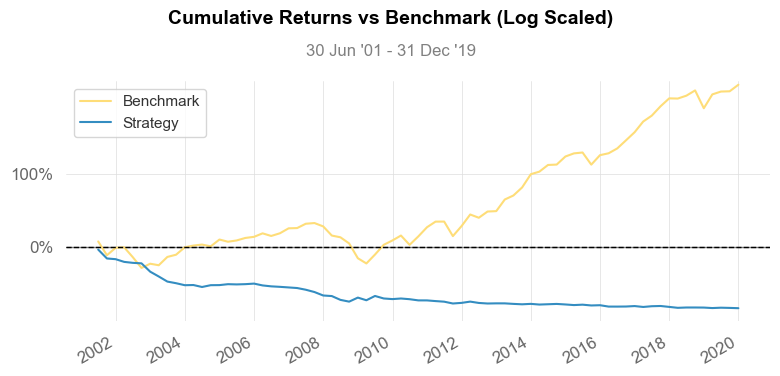

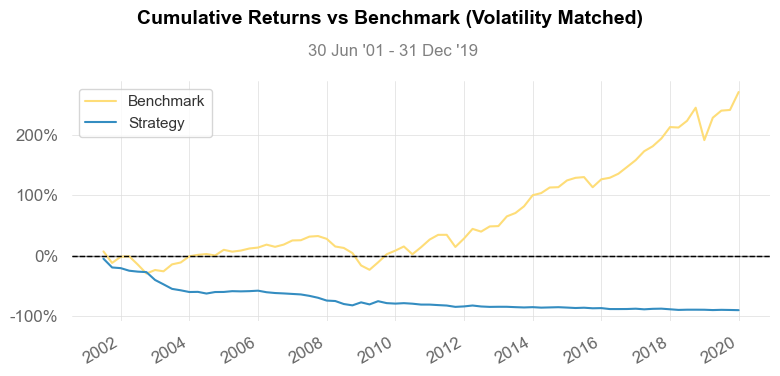

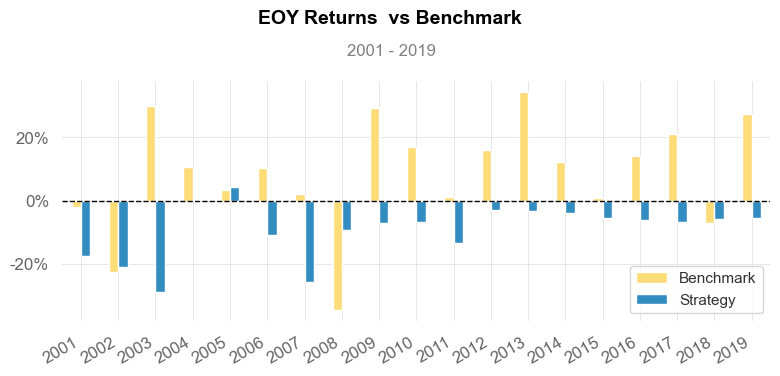

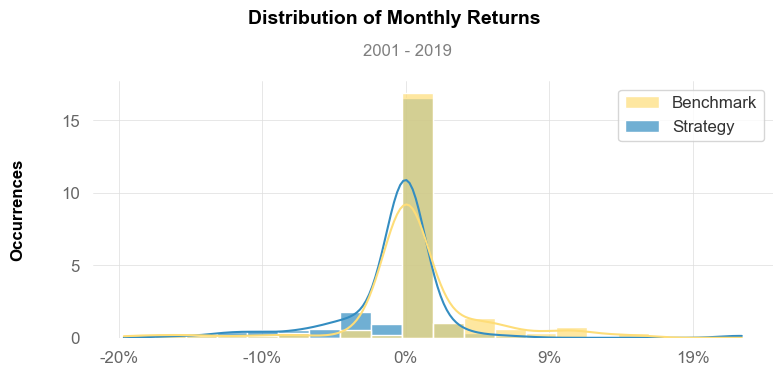

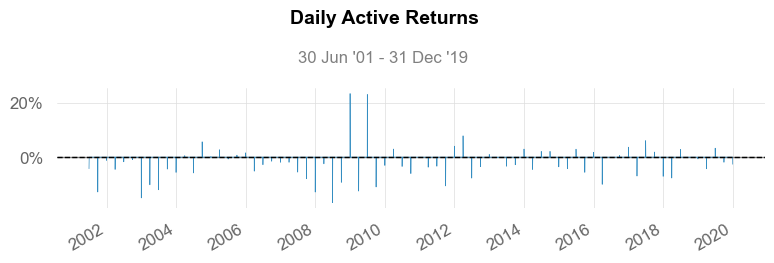

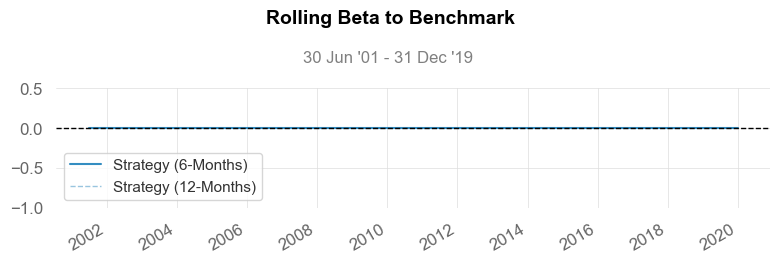

IndexError: index 0 is out of bounds for axis 0 with size 0

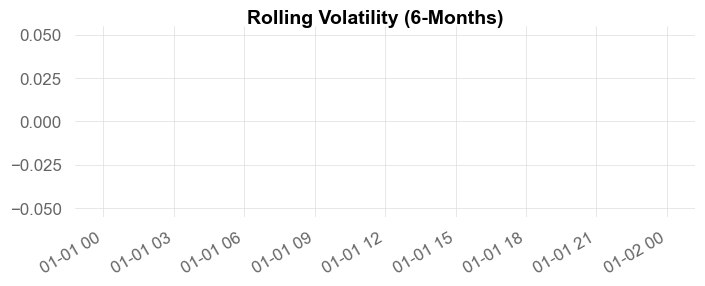

In [58]:
# Backtest
qs.reports.full(alpha_score['score_ret'], alpha_score['mkt_rf'])

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2002-03-31   2002-03-31
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          277.47%      -41.84%
CAGR﹪                     5.3%         -2.08%

Sharpe                     4.48         -2.68
Prob. Sharpe Ratio         98.42%       7.7%
Smart Sharpe               4.38         -2.62
Sortino                    6.84         -3.36
Smart Sortino              6.68         -3.28
Sortino/√2                 4.83         -2.38
Smart Sortino/√2           4.72         -2.32
Omega                      0.65         0.65

Max Drawdown               -42.18%      -52.02%
Longest DD Days            1097         6120
Volatility (ann.)          121.33%      63.07%
R^2                        0.01         0.01
Information Ratio          -0.32        -0.32
Calmar      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2003-03-31,2012-06-30,2019-12-31,6120,-52.0186,-51.4223
2,2002-06-30,2002-06-30,2002-09-30,93,-5.2353,-1.9819


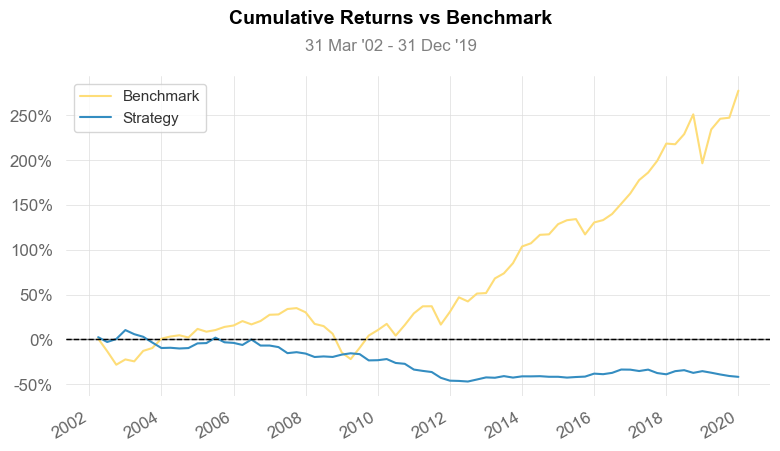

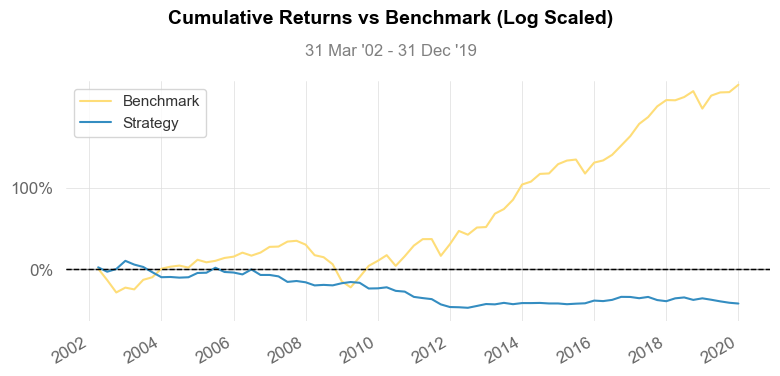

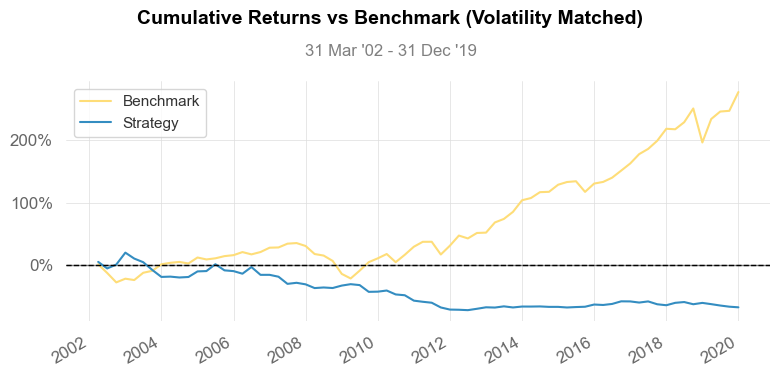

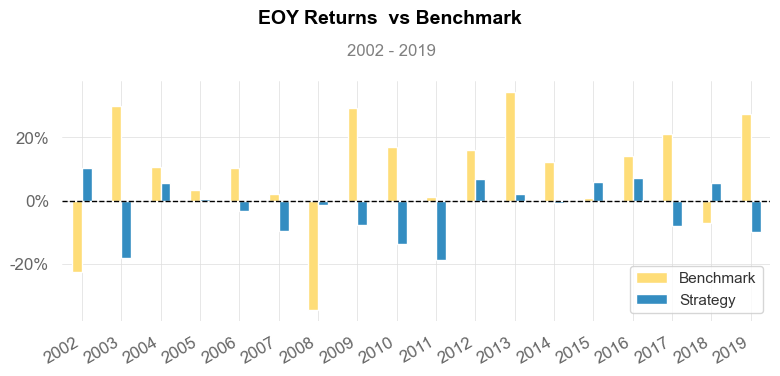

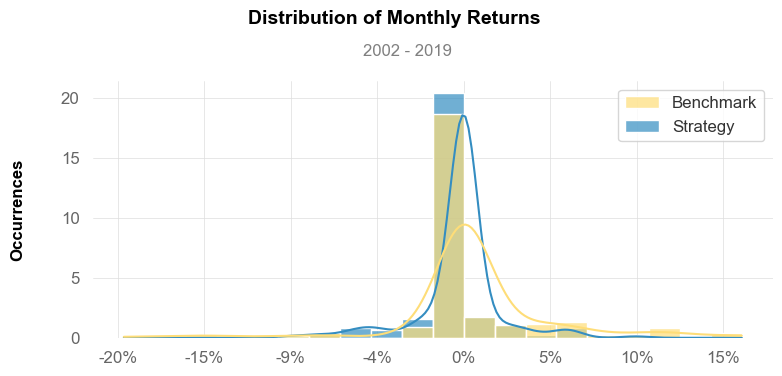

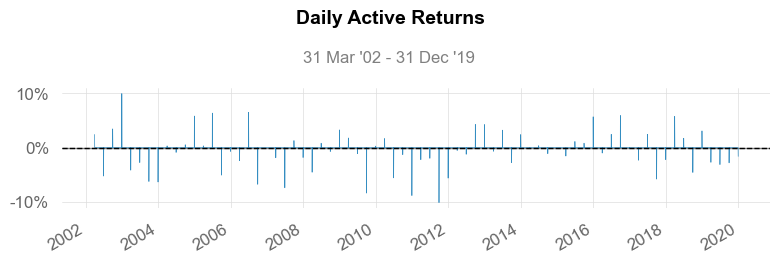

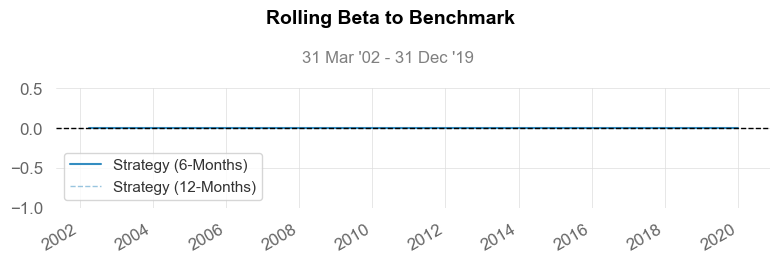

IndexError: index 0 is out of bounds for axis 0 with size 0

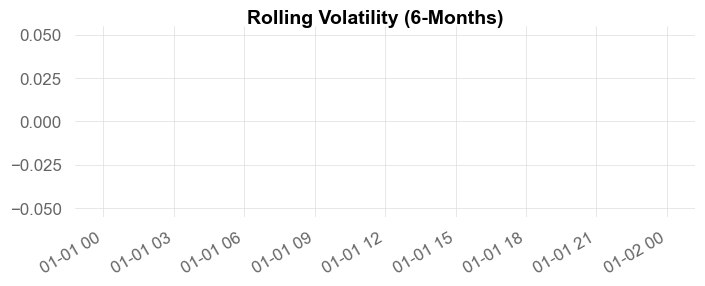

In [59]:
# Backtest
qs.reports.full(alpha_prisk['prisk_ret'], alpha_prisk['mkt_rf'])

### Explain Volatility (ALL)

In [60]:
# Set risk
compare_risk = all_risk[[risk]]

In [61]:
# Join
prisk_vol = compare_risk.join(vol_q)
prisk_vol = prisk_vol.join(asset_q)

In [62]:
# Winsorize
prisk_vol['log_assets'] = np.log(prisk_vol['assets'])
prisk_vol['log_assets'] = winsorize(prisk_vol['log_assets'], limits=[0.01, 0.01])
prisk_vol['PRisk'] = winsorize(prisk_vol['PRisk'], limits=[0.01, 0.01])
prisk_vol['vol'] = winsorize(prisk_vol['vol'], limits=[0.01, 0.01])

In [63]:
# Standardize (divide by the standard deviation)
std_devs = prisk_vol[['PRisk', 'log_assets', 'vol']].std()
prisk_vol['prisk_std'] = prisk_vol['PRisk'] / std_devs['PRisk']
prisk_vol['log_assets_std'] = prisk_vol['log_assets'] / std_devs['log_assets']
prisk_vol['vol_std'] = prisk_vol['vol'] / std_devs['vol']
prisk_vol = prisk_vol.dropna()

In [64]:
# Prisk + Log assets
X = sm.add_constant(prisk_vol[['prisk_std', 'log_assets_std']])
y = prisk_vol['vol_std']

# Create the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print out the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                vol_std   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                 1.457e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        02:08:22   Log-Likelihood:            -2.7899e+05
No. Observations:              209442   AIC:                         5.580e+05
Df Residuals:                  209439   BIC:                         5.580e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.5386      0.007    347.

In [65]:
# Prisk
X = sm.add_constant(prisk_vol[['prisk_std']])
y = prisk_vol['vol_std']

# Create the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print out the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                vol_std   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     184.1
Date:                Thu, 02 May 2024   Prob (F-statistic):           6.52e-42
Time:                        02:08:24   Log-Likelihood:            -2.9253e+05
No. Observations:              209442   AIC:                         5.851e+05
Df Residuals:                  209440   BIC:                         5.851e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3662      0.003    529.844      0.0

### Explain Volatility (SP500)

In [66]:
# Join
attention_vol = compare.join(vol_q)
attention_vol = attention_vol.join(asset_q)

In [67]:
# Winsorize
attention_vol['log_assets'] = np.log(attention_vol['assets'])
attention_vol['log_assets'] = winsorize(attention_vol['log_assets'], limits=[0.01, 0.01])
attention_vol['PRisk'] = winsorize(attention_vol['PRisk'], limits=[0.01, 0.01])
attention_vol['vol'] = winsorize(attention_vol['vol'], limits=[0.01, 0.01])

In [68]:
# Standardize (divide by the standard deviation)
std_devs = attention_vol[['PRisk', 'score', 'log_assets', 'vol']].std()
attention_vol['score_std'] = attention_vol['score'] / std_devs['score']
attention_vol['prisk_std'] = attention_vol['PRisk'] / std_devs['PRisk']
attention_vol['log_assets_std'] = attention_vol['log_assets'] / std_devs['log_assets']
attention_vol['vol_std'] = attention_vol['vol'] / std_devs['vol']
attention_vol = attention_vol.dropna(subset=['score_std', 'log_assets_std', 'vol_std'])

In [71]:
# Alpha
X = sm.add_constant(attention_vol[['score_std', 'log_assets_std']])
y = attention_vol['vol_std']

# Create the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print out the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                vol_std   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     622.3
Date:                Thu, 02 May 2024   Prob (F-statistic):          3.86e-266
Time:                        02:13:32   Log-Likelihood:                -47299.
No. Observations:               33747   AIC:                         9.460e+04
Df Residuals:                   33744   BIC:                         9.463e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.7243      0.032     85.

In [72]:
# Alpha
X = sm.add_constant(attention_vol[['prisk_std', 'log_assets']])
y = attention_vol['vol_std']

# Create the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print out the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                vol_std   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     635.8
Date:                Thu, 02 May 2024   Prob (F-statistic):          8.73e-272
Time:                        02:13:33   Log-Likelihood:                -47286.
No. Observations:               33747   AIC:                         9.458e+04
Df Residuals:                   33744   BIC:                         9.460e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6829      0.031     85.718      0.0

### Predict Excess Return Regression

In [169]:
# Rank Normalize
def rank_normalize(data, exclude_cols):
    def rank_normalize_group(group):
        # Separate the exclude_cols columns if it exists in the group
        if all(col in exclude_cols for col in group.columns):
            exclude_data = group[exclude_cols]
            group = group.drop(columns=exclude_cols, axis=1)
        else:
            exclude_data = None
        # Rank the remaining data
        ranks = group.rank(method='average', na_option='keep')
        # Scale ranks to [-1, 1] range
        min_rank, max_rank = ranks.min(), ranks.max()
        scaled_ranks = -1 + 2.0 * (ranks - min_rank) / (max_rank - min_rank)
        scaled_ranks_df = pd.DataFrame(scaled_ranks, index=group.index, columns=group.columns)
        # Re-include the exclude_cols columns if it was initially present
        if exclude_data is not None:
            scaled_ranks_df = pd.concat([exclude_data, scaled_ranks_df], axis=1)
        return scaled_ranks_df
        
    # Normalize dataset
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.groupby(level='date').apply(rank_normalize_group).reset_index(level=0, drop=True)
    data = data.sort_index(level=['gvkey', 'date'])
    return data

# Cross-sectional Median Imputation
def cross_median(data, exclude_cols):
    # Cross-sectional median imputation on all columns except for exclude_cols
    factor = data.drop(exclude_cols, axis=1)
    daily_median = factor.groupby(level='date').transform('median')
    factor = factor.fillna(daily_median)
    # Fillna with 0 if data for whole entire date is NAN
    factor = factor.fillna(0)
    # Rejoin exclude_cols data and imputed data
    data = pd.concat([data[exclude_cols], factor], axis=1)
    data = data.sort_index(level=['gvkey', 'date'])
    return data
    
# OLS Regression per GVKEY
def ols_gvkey(data, X_cols, y_col, train_ratio):
    results = []
    for gvkey, group in tqdm(data.groupby('gvkey'), desc='Processing GVKEY'):
        split_idx = int(len(group) * train_ratio)
        train = group.iloc[:split_idx]
        test = group.iloc[split_idx:]
        X_train = sm.add_constant(train[X_cols], has_constant='add')
        y_train = train[y_col]
        X_test = sm.add_constant(test[X_cols], has_constant='add')
        y_test = test[y_col]
        model = sm.OLS(y_train, X_train).fit()
        y_pred = model.predict(X_test)
        oos_r_squared = r2_score(y_test, y_pred)

        result = {
            'gvkey': gvkey,
            'R_squared': model.rsquared,
            'adj_R_squared': model.rsquared_adj,
            'f_statistic': model.fvalue,
            'f_p_value': model.f_pvalue,
            'OOS_R_squared': oos_r_squared,
            'intercept': model.params['const']
        }
        for col in X_cols:
            result[f'beta_{col}'] = model.params[col]
            result[f'p_value_{col}'] = model.pvalues[col]
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

# Lasso Regression per GVKEY
def lasso_gvkey(data, X_cols, y_col, alpha, train_ratio):
    results = []
    for gvkey, group in tqdm(data.groupby('gvkey'), desc='Processing GVKEY'):
        split_idx = int(len(group) * train_ratio)
        train = group.iloc[:split_idx]
        test = group.iloc[split_idx:]
        X_train = sm.add_constant(train[X_cols], has_constant='add')
        y_train = train[y_col]
        X_test = sm.add_constant(test[X_cols], has_constant='add')
        y_test = test[y_col]
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        oos_r_squared = r2_score(y_test, y_pred)
        result = {
            'gvkey': gvkey,
            'R_squared': model.score(X_train, y_train),
            'OOS_R_squared': oos_r_squared,
            'intercept': model.intercept_[0]
        }
        for idx, col in enumerate(X_train.columns):
            result[f'beta_{col}'] = model.coef_[idx - 1]
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

# Ridge Regression per GVKEY
def ridge_gvkey(data, X_cols, y_col, alpha, train_ratio):
    results = []
    for gvkey, group in tqdm(data.groupby('gvkey'), desc='Processing GVKEY'):
        split_idx = int(len(group) * train_ratio)
        train = group.iloc[:split_idx]
        test = group.iloc[split_idx:]
        X_train = sm.add_constant(train[X_cols], has_constant='add')
        y_train = train[y_col]
        X_test = sm.add_constant(test[X_cols], has_constant='add')
        y_test = test[y_col]
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        oos_r_squared = r2_score(y_test, y_pred)
        result = {
            'gvkey': gvkey,
            'R_squared': model.score(X_train, y_train),
            'OOS_R_squared': oos_r_squared,
            'intercept': model.intercept_[0]
        }
        for idx, col in enumerate(X_train.columns[1:]): 
            result[f'beta_{col}'] = model.coef_[0][idx]
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

# OLS Regression for entire dataset
def ols(data, X_cols, y_col):
    X = sm.add_constant(data[X_cols])
    y = data[y_col]
    model = sm.OLS(y, X).fit()
    results = {
        'R_squared': model.rsquared,
        'adj_R_squared': model.rsquared_adj,
        'f_statistic': model.fvalue,
        'f_p_value': model.f_pvalue,
        'intercept': model.params['const']
    }
    for col in X_cols:
        results[f'beta_{col}'] = model.params[col]
        results[f'p_value_{col}'] = model.pvalues[col]
    results_df = pd.DataFrame(results, index=[0])
    return results_df

# Display stats
def display_mean_std(data):
    stats_data = {
        'Mean': data.mean(),
        'Standard Deviation': data.std()
    }
    stats_df = pd.DataFrame(stats_data)
    stats_df = stats_df.fillna(0)
    if 'gvkey' in data.columns:
        stats_df = stats_df.iloc[1:]
    display(stats_df)

In [761]:
# Join compare and returns
regress = compare.join(quarterly_ret)
regress = regress.join(quarterly_characteristics)
print(f"Unique Tickers: {len(regress.index.get_level_values('ticker').unique())}")

Unique Tickers: 588


In [762]:
# Rank normalize
exclude_cols = ['ret_exc']
regress = rank_normalize(regress, exclude_cols)
regress = cross_median(regress, ['ret_exc'])
regress = regress.dropna(subset='ret_exc')
print(f"Unique Tickers: {len(regress.index.get_level_values('ticker').unique())}")

Unique Tickers: 542


In [763]:
# Filter out tickers with less than 20 CC
regress = regress.groupby('gvkey').filter(lambda x: len(x) >= 20)
print(f"Unique Tickers with more than 20 CC for score and firm-level risk: {len(regress.index.get_level_values('gvkey').unique())}")

Unique Tickers with more than 20 CC for score and firm-level risk: 532


### OLS

In [764]:
# Univariate OLS Regression per GVKEY
X_cols = ['score']
y_col = ['ret_exc']
train_ratio = 0.8
result = ols_gvkey(data=regress, X_cols=X_cols, y_col=y_col, train_ratio=train_ratio)
display_mean_std(result)

Processing GVKEY: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:01<00:00, 266.02it/s]


,Mean,Standard Deviation
R_squared,0.0280,0.0396
adj_R_squared,0.0057,0.0408
f_statistic,1.3991,2.0614
f_p_value,0.4702,0.3070
OOS_R_squared,-0.2546,2.1216
intercept,-0.0001,0.1473
beta_score,-0.0703,0.2069
p_value_score,0.4702,0.3070


In [765]:
# Univariate OLS Regression per GVKEY
X_cols = ['PRisk']
y_col = ['ret_exc']
train_ratio = 0.8
result = ols_gvkey(data=regress, X_cols=X_cols, y_col=y_col, train_ratio=train_ratio)
display_mean_std(result)

Processing GVKEY: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:02<00:00, 250.53it/s]


,Mean,Standard Deviation
R_squared,0.0241,0.0359
adj_R_squared,0.0018,0.0370
f_statistic,1.1825,1.7876
f_p_value,0.4704,0.2821
OOS_R_squared,-0.2276,1.7255
intercept,0.0038,0.1134
beta_PRisk,-0.0243,0.1853
p_value_PRisk,0.4704,0.2821


In [766]:
# Multivariate OLS Regression per GVKEY
X_cols = ['score', 'PRisk'] + char_col
y_col = ['ret_exc']
train_ratio = 0.8
result = ols_gvkey(data=regress, X_cols=X_cols, y_col=y_col, train_ratio=train_ratio)
display_mean_std(result)

Processing GVKEY: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:03<00:00, 155.72it/s]


,Mean,Standard Deviation
R_squared,0.2110,0.1097
adj_R_squared,0.0395,0.1180
f_statistic,1.3368,0.7038
f_p_value,0.3734,0.2811
OOS_R_squared,-6.8479,67.9343
intercept,-0.5458,19.1155
beta_score,-0.0465,0.2371
p_value_score,0.4816,0.2999
beta_PRisk,-0.0053,0.2238
p_value_PRisk,0.4916,0.2893


In [767]:
# Multivariate OLS Regression Cross-sectionally
X_cols = ['score', 'PRisk'] + char_col
y_col = ['ret_exc']
result = ols(data=regress, X_cols=X_cols, y_col=y_col)
display_mean_std(result)

,Mean,Standard Deviation
R_squared,0.0200,0.0000
adj_R_squared,0.0198,0.0000
f_statistic,85.0202,0.0000
f_p_value,0.0000,0.0000
intercept,-0.0048,0.0000
beta_score,-0.0378,0.0000
p_value_score,0.0000,0.0000
beta_PRisk,0.0051,0.0000
p_value_PRisk,0.3479,0.0000
beta_market_equity,0.2328,0.0000


### Lasso

In [768]:
# Multivariate Lasso Regression per GVKEY
X_cols = ['score', 'PRisk'] + char_col
y_col = ['ret_exc']
train_ratio = 0.8
alpha = 0.10
result = lasso_gvkey(data=regress, X_cols=X_cols, y_col=y_col, alpha=alpha, train_ratio=train_ratio)
display_mean_std(result)

Processing GVKEY: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:04<00:00, 124.75it/s]


,Mean,Standard Deviation
R_squared,0.0053,0.0203
OOS_R_squared,-0.2001,1.6944
intercept,0.0025,0.0930
beta_const,-0.0013,0.0191
beta_score,0.0000,0.0000
beta_PRisk,-0.0035,0.0208
beta_market_equity,-0.0010,0.0212
beta_enterprise_value,0.0000,0.0002
beta_book_equity,0.0000,0.0000
beta_assets,-0.0004,0.0058


### Ridge

In [769]:
# Multivariate Regression per GVKEY
X_cols = ['score', 'PRisk'] + char_col
y_col = ['ret_exc']
train_ratio = 0.8
alpha = 0.10
result = ridge_gvkey(data=regress, X_cols=X_cols, y_col=y_col, alpha=alpha, train_ratio=train_ratio)
display_mean_std(result)

Processing GVKEY: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 532/532 [00:04<00:00, 131.53it/s]


,Mean,Standard Deviation
R_squared,0.1594,0.0853
OOS_R_squared,-0.5461,2.1452
intercept,0.0226,0.7720
beta_score,0.0000,0.0000
beta_PRisk,-0.0552,0.2073
beta_market_equity,-0.0121,0.1882
beta_enterprise_value,0.4301,0.5326
beta_book_equity,0.2778,0.5573
beta_assets,-0.3050,0.6636
beta_sales,-0.1843,0.6603


### WFO Strategy

In [936]:
# All Ret
all_ret = daily_ret.groupby(['gvkey', 'ticker', 'date'])['ret'].apply(lambda x: (1 + x).prod() - 1).to_frame()

In [1006]:
# Tickers
print(all_ret.index.get_level_values('ticker').unique().tolist())

['AAL', 'PNW', 'ABT', 'AMD', 'AET', 'APD', 'ALK', 'HON', 'SWKS', 'HES', 'AEP', 'AXP', 'AFL', 'AIG', 'AME', 'AMGN', 'ADI', 'NBR', 'APA', 'AAPL', 'AMAT', 'ADM', 'ASH', 'ADSK', 'ADP', 'AVY', 'AVP', 'BK', 'BCR', 'BAX', 'BDX', 'VZ', 'BMS', 'BBY', 'BIO', 'HRB', 'BA', 'RHI', 'BMY', 'BC', 'UIS', 'CI', 'CSX', 'CPB', 'STZ', 'CAH', 'CAT', 'JPM', 'CVX', 'CHD', 'CTAS', 'CLF', 'CLX', 'KO', 'CL', 'AON', 'CMCSA', 'CMA', 'C', 'CAR', 'CAG', 'CMS', 'CTB', 'COO', 'TAP', 'GLW', 'CR', 'CCK', 'CMI', 'WEN', 'DHR', 'TGT', 'DE', 'DAL', 'DLX', 'DTE', 'ATGE', 'DIS', 'DG', 'D', 'RRD', 'DOV', 'DD', 'OMC', 'DUK', 'DNB', 'FLS', 'ECL', 'EMR', 'ATO', 'EFX', 'EQT', 'XOM', 'FMC', 'NEE', 'FDX', 'FNMA', 'M', 'FITB', 'RF', 'MTB', 'USB', 'FHN', 'FLR', 'F', 'BEN', 'AJG', 'TGNA', 'GPS', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GT', 'GRA', 'GWW', 'HAL', 'HAS', 'KHC', 'HP', 'HSY', 'HPQ', 'HLT', 'HD', 'HRL', 'CNP', 'HBAN', 'ITT', 'ITW', 'INTC', 'IBM', 'IFF', 'NAV', 'IP', 'IPG', 'JNJ', 'JCI', 'KLAC', 'KMI', 'KSU', 'K', 'KMB', 'KR', 'LRCX'

In [1025]:
# Params
stocks = ['MSFT', 'AAPL', 'GOOGL', 'AMZN']
stocks = ['AAL', 'PNW', 'ABT', 'AMD', 'AET', 'APD', 'ALK', 'HON', 'SWKS', 'HES', 'AEP', 'AXP', 'AFL', 'AIG', 'AME', 'AMGN', 'ADI', 'NBR', 'APA', 'AAPL', 'AMAT', 'ADM', 'ASH', 'ADSK', 'ADP', 'AVY', 'AVP', 'BK', 'BCR', 'BAX', 'BDX', 'VZ', 'BMS', 'BBY', 'BIO', 'HRB', 'BA', 'RHI', 'BMY', 'BC', 'UIS', 'CI', 'CSX', 'CPB', 'STZ', 'CAH', 'CAT', 'JPM', 'CVX', 'CHD', 'CTAS', 'CLF', 'CLX', 'KO', 'CL', 'AON', 'CMCSA']
X_cols = ['market_equity', 'enterprise_value', 'book_equity', 'assets', 'sales', 'net_income']
y_col = 'ret'
alpha = 0.1
train_size = 4*3  # N years of quarterly data
step_size = 1     # Step forward by one quarter each time

In [1026]:
# Placeholder for predictions
preds = []

for stock in stocks:
    print("-"*60 + f"\nProcessing {stock}")
    # Data for stock
    stock_ret = all_ret.loc[all_ret.index.get_level_values('ticker') == stock]
    stock_char = quarterly_characteristics.loc[quarterly_characteristics.index.get_level_values('ticker') == stock]
    stock_all = stock_ret.join(stock_char)
    stock_all = stock_all.dropna()
    
    # Placeholder for results
    returns = []
    
    # Walk-forward optimization loop
    for start in tqdm(range(len(stock_all) - train_size), desc='WFO'):
        # Set end index
        end = start + train_size
        
        # If there isn't enough data left for a test, break the loop
        if end + step_size > len(stock_all):
            break  
            
        # Splitting the data into train and test sets
        train = stock_all.iloc[start:end]
        test = stock_all.iloc[end:end+step_size]
        
        # Prepare the training data
        X_train = sm.add_constant(train[X_cols], has_constant='add')
        y_train = train[y_col]
        
        # Prepare the test data
        X_test = sm.add_constant(test[X_cols], has_constant='add')
        y_test = test[y_col]
        
        # Model training
        model = sm.OLS(y_train, X_train).fit()
        
        # Prediction
        y_pred = model.predict(X_test)
        returns.append(y_pred)

    # Set prediction and returns
    pred = pd.concat(returns, axis=0).to_frame('pred')
    preds.append(pred)

------------------------------------------------------------
Processing AAL


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 270.38it/s]


------------------------------------------------------------
Processing PNW


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 234.91it/s]


------------------------------------------------------------
Processing ABT


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:01<00:00, 186.81it/s]


------------------------------------------------------------
Processing AMD


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 251.75it/s]


------------------------------------------------------------
Processing AET


WFO: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 256.94it/s]


------------------------------------------------------------
Processing APD


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 266.76it/s]


------------------------------------------------------------
Processing ALK


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 259.25it/s]


------------------------------------------------------------
Processing HON


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:01<00:00, 248.32it/s]


------------------------------------------------------------
Processing SWKS


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 257.19it/s]


------------------------------------------------------------
Processing HES


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 255.29it/s]


------------------------------------------------------------
Processing AEP


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 270.58it/s]


------------------------------------------------------------
Processing AXP


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 275.76it/s]


------------------------------------------------------------
Processing AFL


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 281.53it/s]


------------------------------------------------------------
Processing AIG


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 226.21it/s]


------------------------------------------------------------
Processing AME


WFO: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 272.06it/s]


------------------------------------------------------------
Processing AMGN


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 283.66it/s]


------------------------------------------------------------
Processing ADI


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 277.42it/s]


------------------------------------------------------------
Processing NBR


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 272.84it/s]


------------------------------------------------------------
Processing APA


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 262.93it/s]


------------------------------------------------------------
Processing AAPL


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 205.11it/s]


------------------------------------------------------------
Processing AMAT


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 226.05it/s]


------------------------------------------------------------
Processing ADM


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:01<00:00, 256.20it/s]


------------------------------------------------------------
Processing ASH


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 243.93it/s]


------------------------------------------------------------
Processing ADSK


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 225.60it/s]


------------------------------------------------------------
Processing ADP


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 209.36it/s]


------------------------------------------------------------
Processing AVY


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 237.51it/s]


------------------------------------------------------------
Processing AVP


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 217.89it/s]


------------------------------------------------------------
Processing BK


WFO: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 212.30it/s]


------------------------------------------------------------
Processing BCR


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 223.82it/s]


------------------------------------------------------------
Processing BAX


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:01<00:00, 231.26it/s]


------------------------------------------------------------
Processing BDX


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 262.78it/s]


------------------------------------------------------------
Processing VZ


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 242.57it/s]


------------------------------------------------------------
Processing BMS


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 273.72it/s]


------------------------------------------------------------
Processing BBY


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 258.52it/s]


------------------------------------------------------------
Processing BIO


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 251.77it/s]


------------------------------------------------------------
Processing HRB


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 225.11it/s]


------------------------------------------------------------
Processing BA


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:01<00:00, 253.31it/s]


------------------------------------------------------------
Processing RHI


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 274.06it/s]


------------------------------------------------------------
Processing BMY


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:01<00:00, 267.01it/s]


------------------------------------------------------------
Processing BC


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 288.86it/s]


------------------------------------------------------------
Processing UIS


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 181.16it/s]


------------------------------------------------------------
Processing CI


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 272.78it/s]


------------------------------------------------------------
Processing CSX


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 229.25it/s]


------------------------------------------------------------
Processing CPB


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 256.75it/s]


------------------------------------------------------------
Processing STZ


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 278.88it/s]


------------------------------------------------------------
Processing CAH


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 267.23it/s]


------------------------------------------------------------
Processing CAT


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:01<00:00, 272.44it/s]


------------------------------------------------------------
Processing JPM


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 256.38it/s]


------------------------------------------------------------
Processing CVX


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:01<00:00, 269.03it/s]


------------------------------------------------------------
Processing CHD


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 267.23it/s]


------------------------------------------------------------
Processing CTAS


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 211.31it/s]


------------------------------------------------------------
Processing CLF


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 253.26it/s]


------------------------------------------------------------
Processing CLX


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 263.55it/s]


------------------------------------------------------------
Processing KO


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:01<00:00, 255.34it/s]


------------------------------------------------------------
Processing CL


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 275.38it/s]


------------------------------------------------------------
Processing AON


WFO: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 276.40it/s]


------------------------------------------------------------
Processing CMCSA


WFO: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 266.31it/s]


In [1027]:
# Stack predictions
all_pred = pd.concat(preds, axis=0)
all_pred = all_pred.join(all_ret)

In [1028]:
# Signal
all_pred['buy'] = np.where(all_pred['pred'] > 0, 1, 0)

In [1029]:
# Shift ret
all_pred['shift_ret'] = all_pred.groupby('gvkey')['ret'].shift(-1)

In [1030]:
# Total Ret
all_pred['total_ret'] = all_pred['ret'] * all_pred['buy']
strat_ret = all_pred.groupby('date')['total_ret'].mean()

In [1031]:
# Strategy Ret
strat_ret = strat_ret.reset_index().set_index('date')['total_ret']
strat_ret.index = pd.to_datetime(strat_ret.index)

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2004-01-01   2004-01-01
End Period                 2022-10-01   2022-10-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          259.14%      596.0%
CAGR﹪                     4.82%        7.4%

Sharpe                     3.87         9.15
Prob. Sharpe Ratio         97.41%       100.0%
Smart Sharpe               3.54         8.36
Sortino                    5.79         19.46
Smart Sortino              5.29         17.78
Sortino/√2                 4.09         13.76
Smart Sortino/√2           3.74         12.57
Omega                      4.35         4.35

Max Drawdown               -47.47%      -11.84%
Longest DD Days            1828         275
Volatility (ann.)          133.89%      74.13%
R^2                        0.03         0.03
Information Ratio          0.07         0.07
Calmar           

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-01,2020-01-01,2020-07-01,183,-11.8372,-8.0222
2,2008-07-01,2009-01-01,2009-04-01,275,-11.3506,-7.3013
3,2022-04-01,2022-07-01,2022-10-01,184,-8.2006,-6.7091
4,2018-10-01,2018-10-01,2019-01-01,93,-7.5440,-2.8922
5,2011-04-01,2011-07-01,2011-10-01,184,-6.0902,-3.0038


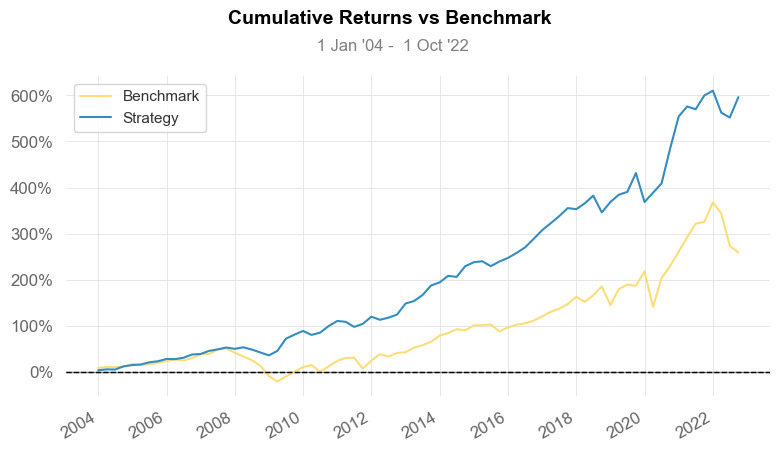

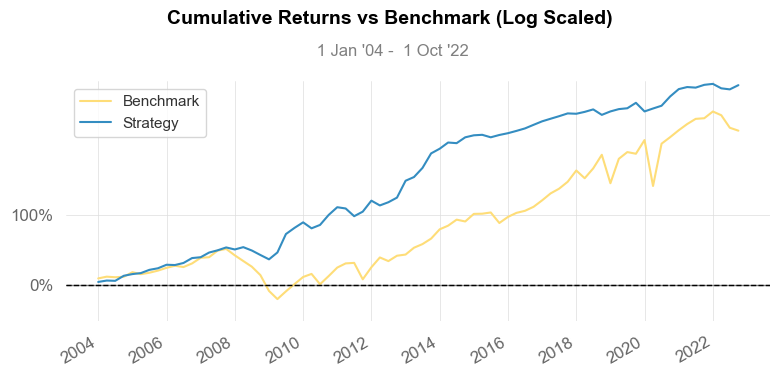

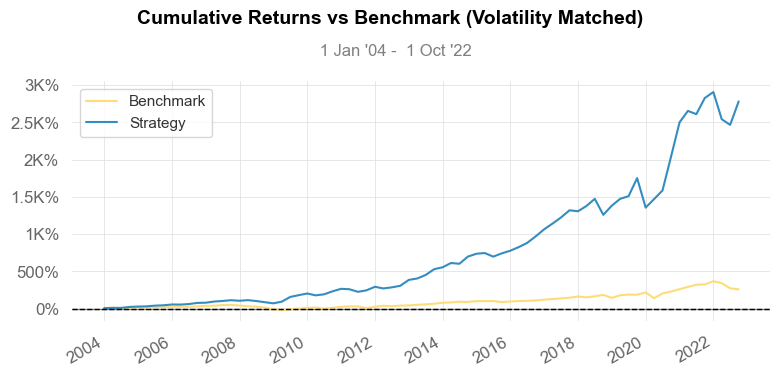

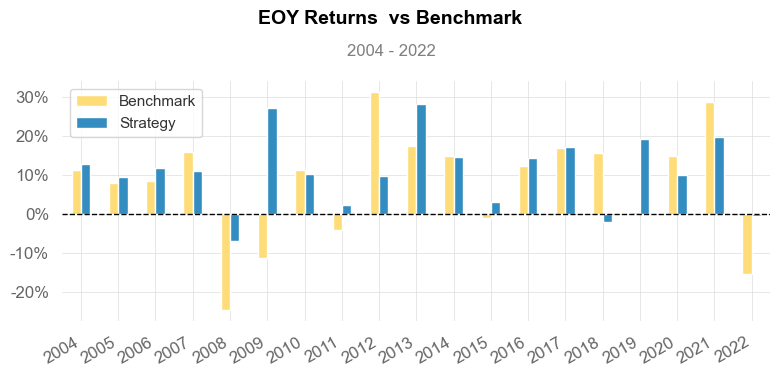

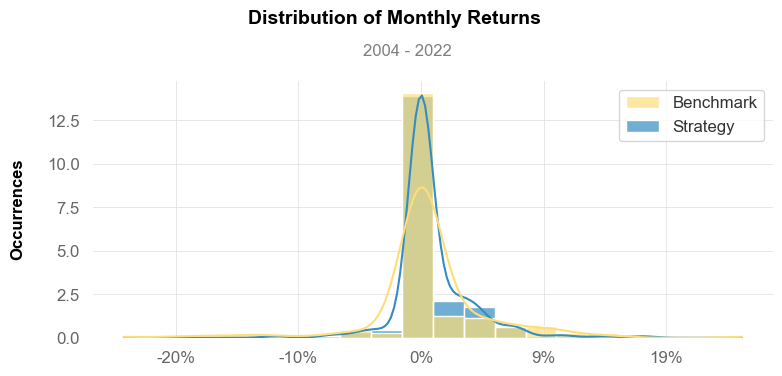

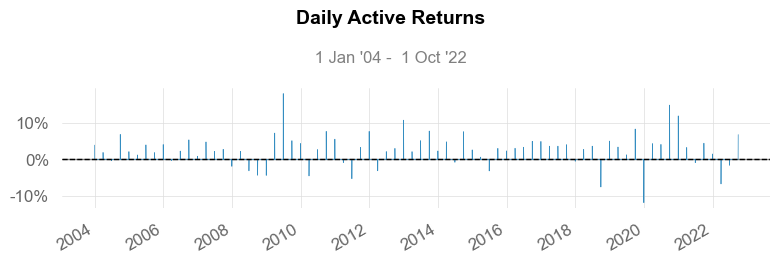

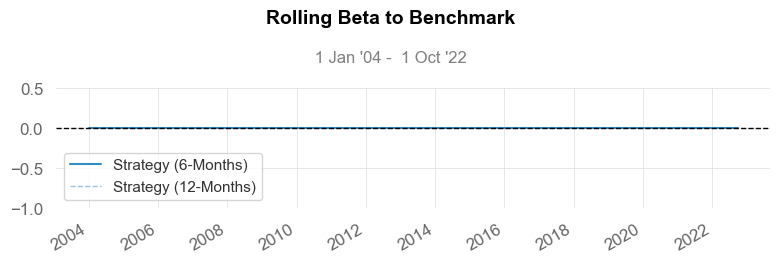

IndexError: index 0 is out of bounds for axis 0 with size 0

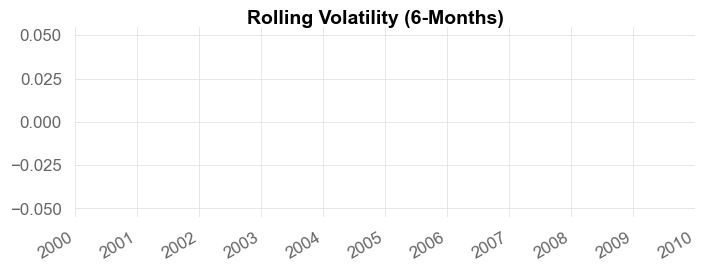

In [1035]:
# Report
qs.reports.full(strat_ret.iloc[4*50:], 'SPY')